<a href="https://colab.research.google.com/github/99doyoon/self_driving_car/blob/fleshman/0504test_real_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from flask import Flask, send_from_directory, jsonify, request, render_template
import os
import cv2
import numpy as np
from PIL import Image
import networkx as nx
import math
from skimage.measure import approximate_polygon
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from collections import deque
import heapq

In [ ]:
def calculate_angle_with_horizontal(cx, cy, fx, fy):
    """
    수평선과 (cx, cy)에서 (fx, fy)로 이어지는 선 사이의 각도를 계산합니다.
    """
    dx = fx - cx
    dy = fy - cy
    angle_radians = math.atan2(dy, dx)
    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

In [ ]:
def find_direction_and_adjust_angle(image_path):
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 파란색의 HSV 범위 정의
    lower_blue = np.array([100, 50, 50])
    upper_blue = np.array([140, 255, 255])

    # 빨간색 영역 추출
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # 컨투어 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    path_process = []

    for contour in contours:
        if cv2.contourArea(contour) < 500:  # 너무 작은 객체는 무시
            continue

        # 객체의 중심점 계산
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            continue  # 중심점을 구할 수 없는 경우는 무시

        # 가장 먼 점 찾기
        extLeft = tuple(contour[contour[:, :, 0].argmin()][0])
        extRight = tuple(contour[contour[:, :, 0].argmax()][0])
        extTop = tuple(contour[contour[:, :, 1].argmin()][0])
        extBot = tuple(contour[contour[:, :, 1].argmax()][0])

        distances = [((extLeft[0]-cX)**2 + (extLeft[1]-cY)**2, extLeft),
                     ((extRight[0]-cX)**2 + (extRight[1]-cY)**2, extRight),
                     ((extTop[0]-cX)**2 + (extTop[1]-cY)**2, extTop),
                     ((extBot[0]-cX)**2 + (extBot[1]-cY)**2, extBot)]

        farthest_point = max(distances, key=lambda x: x[0])[1]

        # 중심점과 가장 먼 점 사이의 각도 계산
        angle = calculate_angle_with_horizontal(cX, cY, farthest_point[0], farthest_point[1])
        print(angle)

        # 각도 조정. 여기서는 0도 방향이 수평 오른쪽이라 가정합니다.
        # 물방울의 뾰족한 부분이 정확히 오른쪽을 향하게 하려면, 그 각도에서
        adjustment_angle = -angle

        # 결과 저장
        path_process.append((cX, cY, adjustment_angle))

        red_mask = cv2.inRange(hsv, lower_blue, upper_blue)
        img[(red_mask != 0)] = [255, 255, 255]

        # 이미지 저장
        cv2.imwrite('/content/map_delet_red.png', img)

    # 모든 물방울에 대한 중심점과 조정 각도 정보가 담긴 리스트 반환
    return path_process

In [ ]:
'''
def find_and_draw_path(image_path, start, end):
    # 이미지 불러오기
    img = Image.open('/content/map_delet_red.png')

    # 이미지를 흑백으로 변환
    img = img.convert('L')

    # 이미지의 픽셀 값을 가져오기
    pixels = img.load()

    # 임계값 설정
    threshold = 128

    # 이진화 수행
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] < threshold:
                pixels[i, j] = 0  # 통과 불가능한 지역
            else:
                pixels[i, j] = 1  # 통과 가능한 지역

    # 그래프 생성
    G = nx.Graph()

    # 모든 픽셀을 노드로 추가
    for i in range(img.width):
        for j in range(img.height):
            G.add_node((i, j))

    # 통과 가능한 픽셀 간 간선 추가
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] == 1:  # 통과 가능한 지역
                # 4방향 연결 고려
                for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    node_x, node_y = i + dx, j + dy
                    if 0 <= node_x < img.width and 0 <= node_y < img.height and pixels[node_x, node_y] == 1:
                        G.add_edge((i, j), (node_x, node_y))

     # Dijkstra 알고리즘을 이용한 최단 경로 찾기
    path = nx.dijkstra_path(G, (start[1],start[0]), (end[1],end[0]))
    # 원본 이미지 불러오기
    img = Image.open(image_path)

    # 이미지 출력 준비
    fig, ax = plt.subplots()

    # 원본 이미지 출력
    ax.imshow(img, cmap='gray')

    # colormap 지정 (점점 진해지는 파란색 계열)
    cmap = plt.get_cmap('Blues')

    # path에 저장된 노드들을 원으로 그리기
    for i, node in enumerate(path):
        circle = plt.Circle((node[1], node[0]), radius=5, color=cmap(i / len(path)), fill=True)
        ax.add_patch(circle)

    # 그래프 출력
    plt.show()

    #가는길 단순화
    # 좌표를 NumPy 배열로 변환
    coords = np.array(path)

    # Douglas-Peucker 알고리즘 적용
    tolerance = 10.0  # 허용 오차 설정
    simplified_coords = approximate_polygon(coords, tolerance)

    # 결과 출력
    print(f"Original number of points: {len(coords)}")
    print(f"Simplified number of points: {len(simplified_coords)}")
    for coord in simplified_coords:
      print(f"Simplified node: x={coord[1]}, y={coord[0]}")
'''

'\ndef find_and_draw_path(image_path, start, end):\n    # 이미지 불러오기\n    img = Image.open(\'/content/map_delet_red.png\')\n\n    # 이미지를 흑백으로 변환\n    img = img.convert(\'L\')\n\n    # 이미지의 픽셀 값을 가져오기\n    pixels = img.load()\n\n    # 임계값 설정\n    threshold = 128\n\n    # 이진화 수행\n    for i in range(img.width):\n        for j in range(img.height):\n            if pixels[i, j] < threshold:\n                pixels[i, j] = 0  # 통과 불가능한 지역\n            else:\n                pixels[i, j] = 1  # 통과 가능한 지역\n\n    # 그래프 생성\n    G = nx.Graph()\n\n    # 모든 픽셀을 노드로 추가\n    for i in range(img.width):\n        for j in range(img.height):\n            G.add_node((i, j))\n\n    # 통과 가능한 픽셀 간 간선 추가\n    for i in range(img.width):\n        for j in range(img.height):\n            if pixels[i, j] == 1:  # 통과 가능한 지역\n                # 4방향 연결 고려\n                for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:\n                    node_x, node_y = i + dx, j + dy\n                    if 0 <= node_x < img.widt

In [ ]:
def get_image_dimensions(image_path):
    """
    지정된 이미지 파일의 가로길이와 세로길이를 반환합니다.

    매개변수:
    - image_path: 이미지 파일의 경로 (str)

    반환값:
    - (width, height): 튜플, 이미지의 가로길이와 세로길이
    """
    # 이미지 파일을 엽니다.
    with Image.open(image_path) as img:
        # img.size는 (가로길이, 세로길이) 형태의 튜플을 반환합니다.
        width, height = img.size

    # 가로길이와 세로길이를 반환합니다.
    return width, height

In [ ]:
def calculate_direction(simplified_coords):
    directions = []
    for i in range(len(simplified_coords)-1):
        x1, y1 = simplified_coords[i]
        x2, y2 = simplified_coords[i+1]

        # 인접한 두 좌표 사이의 벡터 계산
        vec_x = x2 - x1
        vec_y = y2 - y1

        # 외적 계산
        cross_product = vec_x * vec_y

        # 방향 판단
        if cross_product > 0:
            directions.append("l")
        elif cross_product < 0:
            directions.append("r")
        else:
            directions.append("f")

    return directions

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.spatial import distance
from scipy.signal import find_peaks

def draw_point_and_show(image_path, points):
    # 이미지 불러오기
    img = Image.open(image_path)

    # 이미지 상에 그림을 그릴 수 있게 해주는 객체 생성
    draw = ImageDraw.Draw(img)

    # 점 찍기 (예: 빨간색 원으로 표시)
    for point in points:
        # 중심점 주변의 작은 원을 그려서 점처럼 보이게 함
        draw.ellipse(( point[1]-5,point[0]-5, point[1]+5, point[0]+5), fill='red', outline='red')

    # 이미지 출력
    plt.imshow(img)
    plt.show()

def find_and_draw_path(image_path, start, end):
    # 이미지 불러오기
    img = Image.open('/content/map_delet_red.png')

    # 이미지를 흑백으로 변환
    img = img.convert('L')

    # 이미지의 픽셀 값을 가져오기
    pixels = img.load()

    # 임계값 설정
    threshold = 120

    # 이진화 수행
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] < threshold:
                pixels[i, j] = 0  # 통과 불가능한 지역
            else:
                pixels[i, j] = 1  # 통과 가능한 지역

    # 그래프 생성
    G = nx.Graph()

    # 모든 픽셀을 노드로 추가
    for i in range(img.width):
        for j in range(img.height):
            G.add_node((i, j))

    # 통과 가능한 픽셀 간 간선 추가
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] == 1:  # 통과 가능한 지역
                # 4방향 연결 고려
                for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    node_x, node_y = i + dx, j + dy
                    if 0 <= node_x < img.width and 0 <= node_y < img.height and pixels[node_x, node_y] == 1:
                        G.add_edge((i, j), (node_x, node_y))

    # Dijkstra 알고리즘을 이용한 최단 경로 찾기
    path = nx.dijkstra_path(G, (start[1],start[0]), (end[1],end[0]))

    # 원본 이미지 불러오기
    img = Image.open(image_path)

    # 이미지 출력 준비
    fig, ax = plt.subplots()

    # 원본 이미지 출력
    ax.imshow(img, cmap='gray')

    # colormap 지정 (점점 진해지는 파란색 계열)
    cmap = plt.get_cmap('Blues')

    # path에 저장된 노드들을 원으로 그리기
    for i, node in enumerate(path):
        circle = plt.Circle((node[1], node[0]), radius=5, color=cmap(i / len(path)), fill=True)
        ax.add_patch(circle)

    # 그래프 출력
    plt.show()

    # 가는길 단순화
    # 좌표를 NumPy 배열로 변환
    coords = np.array(path)

    # Douglas-Peucker 알고리즘 적용
    tolerance = 10.0  # 허용 오차 설정
    simplified_coords = approximate_polygon(coords, tolerance)

    # 결과 출력
    print(f"Original number of points: {len(coords)}")
    print(f"Simplified number of points: {len(simplified_coords)}")

    draw_point_and_show('/content/map_delet_red.png', simplified_coords)

# 함수 사용 예제
image_path = '/content/map_delet_red.png'
start = (142, 286)
end = (400, 100)
find_and_draw_path(image_path, start, end)

FileNotFoundError: [Errno 2] No such file or directory: '/content/map_delet_red.png'

In [ ]:
x,y=get_image_dimensions('/content/capstonemap.jpg')
x=x/2
y=y/2
print(f"Received coordinates: x={x}, y={y}")
# 여기서 좌표에 따라 필요한 처리를 수행할 수 있습니다.
path_process = find_direction_and_adjust_angle('/content/capstonemap.jpg')
find_and_draw_path('/content/capstonemap.jpg', (320, 240), (x,y))
print("status","success", "x:", x, "y:" ,y)

Received coordinates: x=320.0, y=240.0


FileNotFoundError: [Errno 2] No such file or directory: '/content/map_delet_red.png'

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# 이미지 불러오기
img = Image.open('/content/capstonemap.jpg')

# 이미지를 흑백으로 변환
img = img.convert('L')

# 이진화 수행
pixels = img.load()
threshold = 120
for i in range(img.width):
    for j in range(img.height):
        if pixels[i, j] < threshold:
            pixels[i, j] = 0  # 통과 불가능한 지역
        else:
            pixels[i, j] = 1  # 통과 가능한 지역

# 이진화된 이미지 출력
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='binary')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Binarized Image')
plt.show()


In [ ]:


def make_Graph(image_path):

    # 이미지 불러오기
    img = Image.open(image_path)

    # 이미지를 흑백으로 변환
    img = img.convert('L')

    # 이미지의 픽셀 값을 가져오기
    pixels = img.load()

    # 임계값 설정
    threshold = 128

    # 이진화 수행
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] < threshold:
                pixels[i, j] = 0  # 통과 불가능한 지역
            else:
                pixels[i, j] = 1  # 통과 가능한 지역

    # 그래프 생성
    G = nx.Graph()

    return G

def dijkstra(start, end, graph):

    # 최단 거리 저장
    distance = [float('inf')] * len(G)

    heap = [(0, start)]
    distance[start] = 0

    while heap:
        dist, node = heapq.heappop(heap)

        if node == end:
            return dist

        if distance[node] < dist:
            continue

        for i, weight in enumerate(G[node]):
            if weight > 0:
                new_dist = dist + weight
                if new_dist < distance[i]:
                    distance[i] = new_dist
                    heapq.heappush(heap, (new_dist, i))

    return float('inf')

def get_direction(x, y, nx, ny):
    if x == nx:
        if y < ny:
            return 'f'
        else:
            return 'r'
    else:
        if x < nx:
            return 'r'
        else:
            return 'l'

# 시작점과 목적지 좌표
start_x, start_y = 142, 286
end_x, end_y = 400, 100

G= make_Graph('/content/map_delet_red.png')
shortest_distance = dijkstra((start_x, start_y), (end_x, end_y),G)
print(f"최단 거리: {shortest_distance}")


# 최단 거리와 갈림길 행동 양식 저장
distance = [float('inf')] * (len(G) * len(G[0]))
directions = []
# 갈림길 행동 양식 저장
x, y = start_x, start_y
while (x, y) != (end_x, end_y):
    for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < len(G) and 0 <= ny < len(G[0]) and G[nx][ny] == 0 and distance[nx * len(G[0]) + ny] == distance[x * len(G[0]) + y] + 1:
            directions.append(get_direction(x, y, nx, ny))
            x, y = nx, ny
            break

print("갈림길 행동 양식:", ", ".join(directions))


FileNotFoundError: [Errno 2] No such file or directory: '/content/map_delet_red.png'

In [ ]:
def find_and_draw_path(image_path, start, end):
      # 이미지 불러오기
    img = Image.open(image_path)


    # 이미지를 흑백으로 변환
    img = img.convert('L')

    # 이미지의 픽셀 값을 가져오기
    pixels = img.load()

    # 임계값 설정
    threshold = 128

    # 이진화 수행
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] < threshold:
                pixels[i, j] = 0  # 통과 불가능한 지역
            else:
                pixels[i, j] = 1  # 통과 가능한 지역

    # 그래프 생성
    G = nx.Graph()

    # 모든 픽셀을 노드로 추가
    for i in range(img.width):
        for j in range(img.height):
            G.add_node((i, j))

    # 통과 가능한 픽셀 간 간선 추가
    for i in range(img.width):
        for j in range(img.height):
            if pixels[i, j] == 1:  # 통과 가능한 지역
                # 4방향 연결 고려
                for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
                    node_x, node_y = i + dx, j + dy
                    if 0 <= node_x < img.width and 0 <= node_y < img.height and pixels[node_x, node_y] == 1:
                        G.add_edge((i, j), (node_x, node_y))


    # 최단 경로 찾기
    path = nx.dijkstra_path(G, (start[1],start[0]), (end[1],end[0]))

    # 갈림길 찾기
    junctions = []
    for i in range(len(path)-1):
        node = path[i]
        neighbors = list(G.neighbors(node))
        if len(neighbors) > 1:
            junctions.append(node)

    # 원본 이미지 불러오기
    img = Image.open(image_path)

    # 이미지 출력 준비
    fig, ax = plt.subplots()

    # 원본 이미지 출력
    ax.imshow(img, cmap='gray')

    # colormap 지정 (점점 진해지는 파란색 계열)
    cmap = plt.get_cmap('Blues')

    # path에 저장된 노드들을 원으로 그리기
    for i, node in enumerate(path):
        circle = plt.Circle((node[1], node[0]), radius=5, color=cmap(i / len(path)), fill=True)
        ax.add_patch(circle)

    # 갈림길 표시하기
    for junction in junctions:
        circle = plt.Circle((junction[1], junction[0]), radius=10, color='red', fill=False)
        ax.add_patch(circle)

    # 그래프 출력
    plt.show()

start_x, start_y = 142, 286
end_x, end_y = 400, 100
find_and_draw_path('/content/map_delet_red.png', (start_x, start_y), (end_x, end_y))

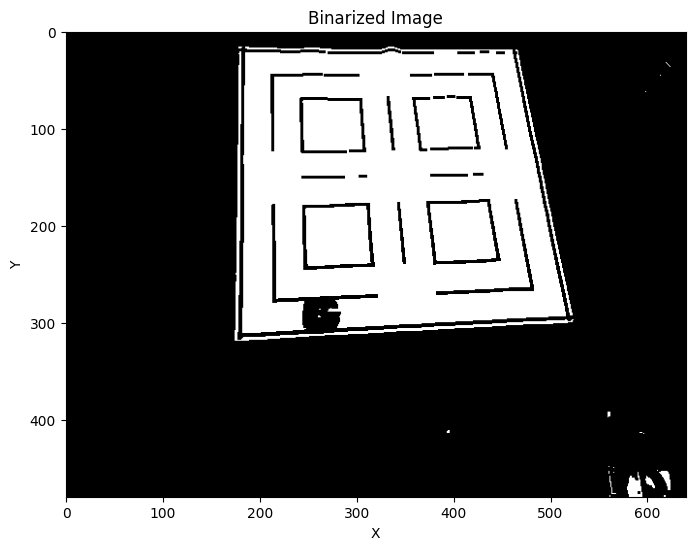

Image preprocessing completed
Intersection detection completed
Intersection types: ['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown', 'Un

DisabledFunctionError: cv2.imshow() is disabled in Colab, because it causes Jupyter sessions
to crash; see https://github.com/jupyter/notebook/issues/3935.
As a substitution, consider using
  from google.colab.patches import cv2_imshow


In [ ]:
# 이미지 전처리 함수
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3,3), np.uint8)
    processed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    plt.figure(figsize=(8, 8))
    plt.imshow(processed, cmap='binary')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Binarized Image')
    plt.show()
    return processed

# 허프 변환으로 선분 추출 함수
def extract_lines(img):
  lines = cv2.HoughLinesP(img, 1, np.pi/180, 100, minLineLength=50, maxLineGap=20)
  return lines

# 교차점 탐지 함수
def find_intersections(lines):
    intersections = []
    for i in range(len(lines)):
        for j in range(i+1, len(lines)):
            x1, y1, x2, y2 = lines[i][0]
            x3, y3, x4, y4 = lines[j][0]

            if (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4) != 0:
                px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
                py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
                intersections.append((int(px), int(py)))

    #print(f"Number of intersections detected: {len(intersections)}")
    return intersections

# 교차로 분류 함수
def classify_intersection(img, intersection, radius=20):
    cx, cy = intersection
    roi = img[cy-radius:cy+radius, cx-radius:cx+radius]

    lines = extract_lines(roi)
    if not lines:
        intersection_type = "Unknown"
    else:
        num_branches = len(lines)
        if num_branches == 3:
            intersection_type = "T-intersection"
        elif num_branches == 4:
            intersection_type = "Crossroad"
        else:
            intersection_type = "Unknown"

    #print(f"Intersection at ({cx}, {cy}) classified as: {intersection_type}")
    return intersection_type

# 메인 함수
def detect_intersections(img_path):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)
    print("Image preprocessing completed")

    lines = extract_lines(processed)
    intersections = find_intersections(lines)

    intersection_types = []
    for intersection in intersections:
        intersection_type = classify_intersection(processed, intersection)
        intersection_types.append(intersection_type)
        cv2.circle(img, intersection, 5, (0, 0, 255), -1)
        cv2.putText(img, intersection_type, intersection, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36,255,12), 2)

    print("Intersection detection completed")
    print("Intersection types:", intersection_types)

    cv2.imshow("Intersections", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# 사용 예시
detect_intersections("/content/capstonemap.jpg")

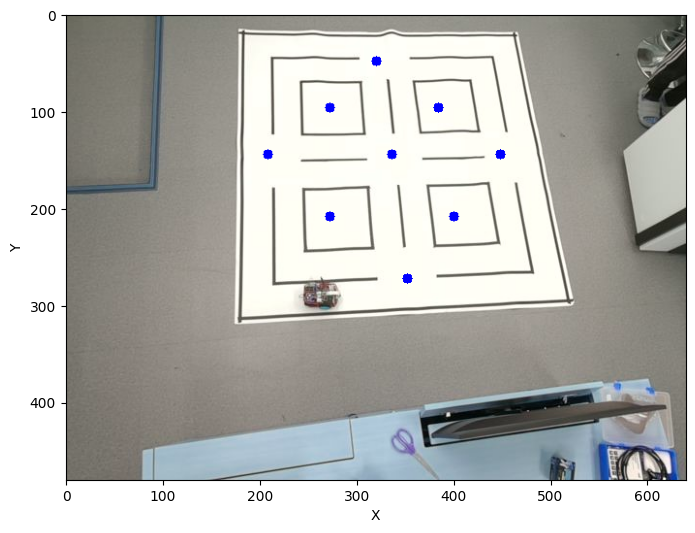

In [ ]:
import cv2
import numpy as np

# 이미지 전처리 함수
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    return binary

# 교차로 탐지 함수
def detect_intersections(img):
    intersections = []
    height, width = img.shape
    window_size = 33
    min_distance = window_size  # 최소 거리 임계값

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                # 기존 교차로와의 거리 계산
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break

                # 최소 거리 이상이면 교차로로 인식
                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))

    return intersections

# 메인 함수
def main(img_path):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)

    intersections = detect_intersections(processed)

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.xlabel('X')
    plt.ylabel('Y')

# 사용 예시
main("/content/capstonemap.jpg")


In [ ]:
import cv2
import numpy as np
from collections import deque
import heapq

window_size = 33
error = 10

# 이미지 전처리 함수
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    return binary

# 교차로 탐지 함수
def detect_intersections(img):
    intersections = []
    height, width = img.shape
    min_distance = window_size  # 최소 거리 임계값

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break

                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))

    return intersections

# Dijkstra 알고리즘을 사용한 최단 경로 탐색
def find_shortest_path(img, start, end):
    height, width = img.shape
    queue = []
    heapq.heappush(queue, (0, start))
    cost_visited = np.full((height, width), np.inf)
    cost_visited[start] = 0
    directions = np.full((height, width), None, dtype=object)

    while queue:
        current_cost, curr_pos = heapq.heappop(queue)
        x, y = curr_pos

        if curr_pos == end:
            break

        if current_cost > cost_visited[y, x]:
            continue

        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

        for nx, ny in neighbors:
            if 0 <= nx < width and 0 <= ny < height and img[ny, nx] == 0:
                new_cost = current_cost + 1
                if new_cost < cost_visited[ny, nx]:
                    cost_visited[ny, nx] = new_cost
                    heapq.heappush(queue, (new_cost, (nx, ny)))
                    directions[ny, nx] = (ny - y, nx - x)  # 방향 저장

    # 최단 경로 추적
    path = []
    curr_pos = end
    while curr_pos != start:
        path.append(curr_pos)
        dx, dy = directions[curr_pos]
        curr_pos = (curr_pos[0] - dy, curr_pos[1] - dx)
    path.append(start)
    path.reverse()

    return path

# 메인 함수
def main(img_path, start, end):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)

    intersections = detect_intersections(processed)
    shortest_path = find_shortest_path(processed, start, end)

    if not shortest_path:
        print("No path found between the start and end points.")
        return

    print(f"Shortest path: {shortest_path}")

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    # 경로 시각화
    for i in range(len(shortest_path) - 1):
        curr_pos = shortest_path[i]
        next_pos = shortest_path[i + 1]
        x1, y1 = curr_pos
        x2, y2 = next_pos
        cv2.arrowedLine(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5
        direction = get_direction(x2 - x1, y2 - y1)
        cv2.putText(img, f"{direction} ({int(distance)})", (x2 + 10, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 2)

    cv2.circle(img, start, 5, (0, 0, 255), -1)
    cv2.circle(img, end, 5, (0, 0, 255), -1)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def get_direction(dx, dy):
    if dx == 0 and dy > 0:
        return "Down"
    elif dx == 0 and dy < 0:
        return "Up"
    elif dx > 0 and dy == 0:
        return "Right"
    elif dx < 0 and dy == 0:
        return "Left"
    elif dx > 0 and dy > 0:
        return "Down-Right"
    elif dx > 0 and dy < 0:
        return "Up-Right"
    elif dx < 0 and dy > 0:
        return "Down-Left"
    else:
        return "Up-Left"

start = (142, 286)
end = (400, 100)
main('/content/capstonemap.jpg', start, end)



TypeError: cannot unpack non-iterable NoneType object

Shortest path: [(251, 48), (252, 48), (253, 48), (254, 48), (255, 48), (256, 48), (257, 48), (258, 48), (259, 48), (260, 48), (261, 48), (262, 48), (263, 48), (264, 48), (265, 48), (266, 48), (267, 48), (268, 48), (269, 48), (270, 48), (271, 48), (272, 48), (273, 48), (274, 48), (275, 48), (276, 48), (277, 48), (278, 48), (279, 48), (280, 48), (281, 48), (282, 48), (283, 48), (284, 48), (285, 48), (286, 48), (287, 48), (288, 48), (289, 48), (290, 48), (291, 48), (292, 48), (293, 48), (294, 48), (295, 48), (296, 48), (297, 48), (298, 48), (299, 48), (300, 48), (301, 48), (302, 48), (303, 48), (304, 48), (305, 48), (306, 48), (307, 48), (308, 48), (309, 48), (310, 48), (311, 48), (312, 48), (313, 48), (314, 48), (315, 48), (316, 48), (317, 48), (318, 48), (319, 48), (320, 48), (321, 48), (322, 48), (323, 48), (324, 48), (325, 48), (326, 48), (327, 48), (328, 48), (329, 48), (330, 48), (331, 48), (332, 48), (333, 48), (334, 48), (335, 48), (336, 48), (337, 48), (338, 48), (339, 48), (340,

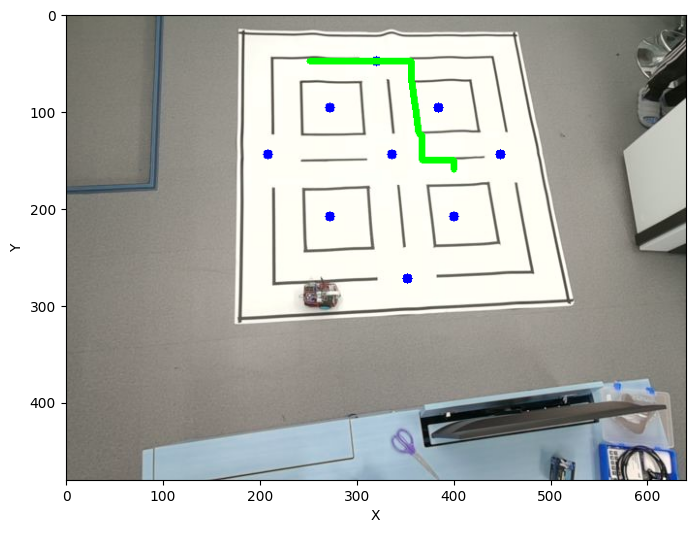

In [ ]:
####그나마 가능성이
window_size = 33
error=10

# 이미지 전처리 함수
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    return binary

# 교차로 탐지 함수
def detect_intersections(img):
    intersections = []
    height, width = img.shape

    min_distance = window_size  # 최소 거리 임계값

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break

                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))

    return intersections

# BFS 알고리즘을 사용한 최단 경로 탐색
def find_shortest_path(img, start, end):
    height, width = img.shape
    queue = deque([(start, [])])
    visited = set()

    while queue:
        curr_pos, path = queue.popleft()
        if curr_pos == end:
            return path + [curr_pos]

        if curr_pos in visited:
            continue

        visited.add(curr_pos)

        x, y = curr_pos
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

        for nx, ny in neighbors:
            if 0 <= nx < width and 0 <= ny < height and img[ny, nx] == 0:
                new_path = path + [(nx, ny)]
                queue.append(((nx, ny), new_path))

    return []

# 메인 함수
def main(img_path, start, end):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)

    intersections = detect_intersections(processed)
    shortest_path = find_shortest_path(processed, start, end)

    if not shortest_path:
        print("No path found between the start and end points.")
        return

    print(f"Shortest path: {shortest_path}")

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    # 경로 시각화
    for pos in shortest_path:
        x, y = pos
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

    printed_coords = set()  # 이미 출력된 좌표들을 저장할 집합

    # 교차로 근처를 지나는 좌표 출력
    for j in range(max(0, i-error), min(len(shortest_path), i+error+1)):
        x, y = shortest_path[j]
        if (x - window_size // 2 <= cx <= x + window_size // 2 and y - window_size // 2 <= cy <= y + window_size // 2):
            # 이미 출력된 좌표와의 거리가 너무 가까우면 출력하지 않음
            too_close = False
            for px, py in printed_coords:
                distance = ((x - px) ** 2 + (y - py) ** 2) ** 0.5
                if distance < error:
                    too_close = True
                    break

                if not too_close:
                    print(f"Passing near intersection at ({x}, {y})")
                    printed_coords.add((x, y))

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.xlabel('X')
    plt.ylabel('Y')
#[(320, 48), (272, 96), (384, 96), (208, 144), (336, 144), (448, 144), (272, 208), (400, 208), (352, 272)]
start = (250, 48)
end = (400, 160)
main('/content/capstonemap.jpg', start, end)

In [ ]:
ㅆㅇimport cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    return binary

def detect_intersections(img):
    intersections = []
    height, width = img.shape
    window_size = 33
    min_distance = window_size

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break
                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))
    return intersections

# Dijkstra 알고리즘 구현
def dijkstra(graph, start, end):
    shortest_distance = {}
    predecessor = {}
    unseen_nodes = graph
    infinity = 9999999
    path = []
    for node in unseen_nodes:
        shortest_distance[node] = infinity
    shortest_distance[start] = 0

    while unseen_nodes:
        min_node = None
        for node in unseen_nodes:
            if min_node is None:
                min_node = node
            elif shortest_distance[node] < shortest_distance[min_node]:
                min_node = node

        for child_node, weight in graph[min_node].items():
            if weight + shortest_distance[min_node] < shortest_distance[child_node]:
                shortest_distance[child_node] = weight + shortest_distance[min_node]
                predecessor[child_node] = min_node
        unseen_nodes.pop(min_node)

    currentNode = end
    while currentNode != start:
        try:
            path.insert(0, currentNode)
            currentNode = predecessor[currentNode]
        except KeyError:
            print('Path not reachable')
            break
    path.insert(0, start)
    if shortest_distance[end] != infinity:
        print('Shortest distance is ' + str(shortest_distance[end]))
        print('And the path is ' + str(path))

    return path

# 노드 간 거리 계산 함수
def calculate_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

# 메인 함수
def main(img_path):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)
    intersections = detect_intersections(processed)

    print(intersections)

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (255, 0, 0), -1)

    # 교차점들을 기반으로 그래프 생성 (여기서는 간단하게 모든 교차점을 서로 연결한다고 가정)
    graph = {}
    for i, start in enumerate(intersections):
        distances = {}
        for j, end in enumerate(intersections):
            if i != j:
                distances[j] = calculate_distance(start, end)
        graph[i] = distances

    start = (319, 48)
    end = (351, 272)
    # 최단 경로 찾기 (예시로 첫 번째 교차점에서 마지막 교차점까지)
    path = dijkstra(graph, start, end)

    # 경로에 따라 이미지에 표시
    for point in path:
        x, y = intersections[point]
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# 사용 예시
main("/content/capstonemap.jpg")

[(320, 48), (272, 96), (384, 96), (208, 144), (336, 144), (448, 144), (272, 208), (400, 208), (352, 272)]
Path not reachable


KeyError: (351, 272)

Shortest path: [(251, 48), (252, 48), (253, 48), (254, 48), (255, 48), (256, 48), (257, 48), (258, 48), (259, 48), (260, 48), (261, 48), (262, 48), (263, 48), (264, 48), (265, 48), (266, 48), (267, 48), (268, 48), (269, 48), (270, 48), (271, 48), (272, 48), (273, 48), (274, 48), (275, 48), (276, 48), (277, 48), (278, 48), (279, 48), (280, 48), (281, 48), (282, 48), (283, 48), (284, 48), (285, 48), (286, 48), (287, 48), (288, 48), (289, 48), (290, 48), (291, 48), (292, 48), (293, 48), (294, 48), (295, 48), (296, 48), (297, 48), (298, 48), (299, 48), (300, 48), (301, 48), (302, 48), (303, 48), (304, 48), (305, 48), (306, 48), (307, 48), (308, 48), (309, 48), (310, 48), (311, 48), (312, 48), (313, 48), (314, 48), (315, 48), (316, 48), (317, 48), (318, 48), (319, 48), (320, 48), (321, 48), (322, 48), (323, 48), (324, 48), (325, 48), (326, 48), (327, 48), (328, 48), (329, 48), (330, 48), (331, 48), (332, 48), (333, 48), (334, 48), (335, 48), (336, 48), (337, 48), (338, 48), (339, 48), (340,

<ipython-input-76-34a488366c67>:133: RuntimeWarning: invalid value encountered in divide
  unit_vector_b = vector_b / np.linalg.norm(vector_b)


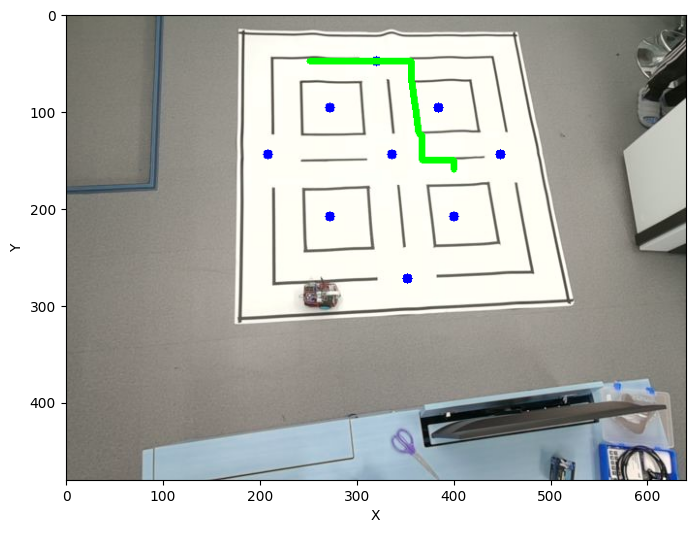

In [ ]:
####그나마 가능성이
window_size = 33
error=10

# 이미지 전처리 함수
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    return binary

# 교차로 탐지 함수
def detect_intersections(img):
    intersections = []
    height, width = img.shape

    min_distance = window_size  # 최소 거리 임계값

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break

                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))

    return intersections

# BFS 알고리즘을 사용한 최단 경로 탐색
def find_shortest_path(img, start, end):
    height, width = img.shape
    queue = deque([(start, [])])
    visited = set()

    while queue:
        curr_pos, path = queue.popleft()
        if curr_pos == end:
            return path + [curr_pos]

        if curr_pos in visited:
            continue

        visited.add(curr_pos)

        x, y = curr_pos
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

        for nx, ny in neighbors:
            if 0 <= nx < width and 0 <= ny < height and img[ny, nx] == 0:
                new_path = path + [(nx, ny)]
                queue.append(((nx, ny), new_path))

    return []

# 메인 함수
def main(img_path, start, end):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)

    intersections = detect_intersections(processed)
    shortest_path = find_shortest_path(processed, start, end)

    if not shortest_path:
        print("No path found between the start and end points.")
        return

    print(f"Shortest path: {shortest_path}")

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    # 경로 시각화
    for pos in shortest_path:
        x, y = pos
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

    printed_coords = set()  # 이미 출력된 좌표들을 저장할 집합

    # 교차로 근처를 지나는 좌표 출력
    for j in range(max(0, i-error), min(len(shortest_path), i+error+1)):
        x, y = shortest_path[j]
        if (x - window_size // 2 <= cx <= x + window_size // 2 and y - window_size // 2 <= cy <= y + window_size // 2):
            # 이미 출력된 좌표와의 거리가 너무 가까우면 출력하지 않음
            too_close = False
            for px, py in printed_coords:
                distance = ((x - px) ** 2 + (y - py) ** 2) ** 0.5
                if distance < window_size:
                    too_close = True
                    break

                if not too_close:
                    print(f"Passing near intersection at ({x}, {y})")
                    printed_coords.add((x, y))

    directions = []  # 방향을 저장할 리스트

    for k in range(1, len(shortest_path) - 1):
        prev_pos = shortest_path[k - 1]
        curr_pos = shortest_path[k]
        next_pos = shortest_path[k + 1]

        angle = calculate_angle(prev_pos, curr_pos, next_pos)

        # 각도에 따라 방향 판단 (예시)
        if angle > 160:  # 거의 직진으로 가정
            direction = "직진"
        elif angle < 100:  # 우회전으로 가정
            direction = "오른쪽"
        else:  # 좌회전으로 가정
            direction = "왼쪽"

        directions.append(direction)

    print(directions)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.xlabel('X')
    plt.ylabel('Y')

def calculate_angle(prev_pos, curr_pos, next_pos):
    # 벡터 계산
    vector_a = np.array(prev_pos) - np.array(curr_pos)
    vector_b = np.array(next_pos) - np.array(curr_pos)

    # 단위 벡터로 변환
    unit_vector_a = vector_a / np.linalg.norm(vector_a)
    unit_vector_b = vector_b / np.linalg.norm(vector_b)

    # 두 벡터 사이의 각도 계산
    dot_product = np.dot(unit_vector_a, unit_vector_b)
    angle = np.arccos(dot_product)

    # 각도를 도(degree) 단위로 변환
    angle_degree = np.degrees(angle)

    return angle_degree

#[(320, 48), (272, 96), (384, 96), (208, 144), (336, 144), (448, 144), (272, 208), (400, 208), (352, 272)]
start = (250, 48)
end = (400, 160)
main('/content/capstonemap.jpg', start, end)

Shortest path: [(251, 48), (252, 48), (253, 48), (254, 48), (255, 48), (256, 48), (257, 48), (258, 48), (259, 48), (260, 48), (261, 48), (262, 48), (263, 48), (264, 48), (265, 48), (266, 48), (267, 48), (268, 48), (269, 48), (270, 48), (271, 48), (272, 48), (273, 48), (274, 48), (275, 48), (276, 48), (277, 48), (278, 48), (279, 48), (280, 48), (281, 48), (282, 48), (283, 48), (284, 48), (285, 48), (286, 48), (287, 48), (288, 48), (289, 48), (290, 48), (291, 48), (292, 48), (293, 48), (294, 48), (295, 48), (296, 48), (297, 48), (298, 48), (299, 48), (300, 48), (301, 48), (302, 48), (303, 48), (304, 48), (305, 48), (306, 48), (307, 48), (308, 48), (309, 48), (310, 48), (311, 48), (312, 48), (313, 48), (314, 48), (315, 48), (316, 48), (317, 48), (318, 48), (319, 48), (320, 48), (321, 48), (322, 48), (323, 48), (324, 48), (325, 48), (326, 48), (327, 48), (328, 48), (329, 48), (330, 48), (331, 48), (332, 48), (333, 48), (334, 48), (335, 48), (336, 48), (337, 48), (338, 48), (339, 48), (340,

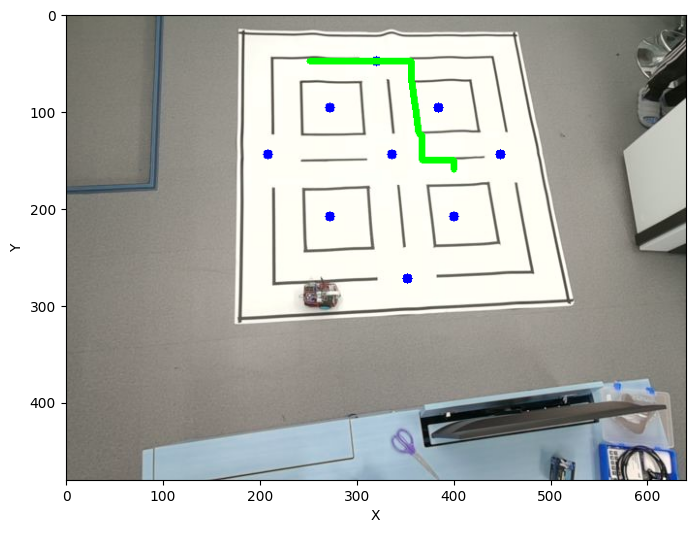

In [10]:
import cv2
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from math import sqrt

window_size = 33
error = 10

def point_line_distance(point, start, end):
    if start == end:
        return sqrt((point[0] - start[0])**2 + (point[1] - start[1])**2)
    else:
        num = abs((end[1] - start[1])*point[0] - (end[0] - start[0])*point[1] + end[0]*start[1] - end[1]*start[0])
        den = sqrt((end[1] - start[1])**2 + (end[0] - start[0])**2)
        return num / den

def ramer_douglas_peucker(points, epsilon):
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        rec_results1 = ramer_douglas_peucker(points[:index+1], epsilon)
        rec_results2 = ramer_douglas_peucker(points[index:], epsilon)

        return rec_results1[:-1] + rec_results2
    else:
        return [points[0], points[-1]]

def direction_from_points(p1, p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    if dx > 0:
        return 'E'
    elif dx < 0:
        return 'W'
    elif dy > 0:
        return 'N'
    else:
        return 'S'

def turn_direction(current, target):
    directions = ['N', 'E', 'S', 'W']
    ci = directions.index(current)
    ti = directions.index(target)
    if (ci - ti) % 4 == 1 or (ci - ti) == -3:
        return 'l'
    else:
        return 'r'

def generate_path_commands(initial_direction, points):
    if len(points) < 2:
        return "경로가 너무 짧습니다."

    commands = []
    direction = initial_direction
    first_move_direction = direction_from_points(points[0], points[1])

    # 초기 방향과 첫 이동 방향이 다른 경우 회전 명령 추가
    if direction != first_move_direction:
        turn = turn_direction(direction, first_move_direction)
        commands.append((turn, 0))  # 회전인 경우 거리는 0
        direction = first_move_direction

    for i in range(len(points)-1):
        next_direction = direction_from_points(points[i], points[i+1])

        # 다음 이동 방향에 대한 회전이 필요한 경우
        if direction != next_direction:
            turn = turn_direction(direction, next_direction)
            commands.append((turn, 0))  # 회전인 경우 거리는 0
            direction = next_direction

        # 현재 지점과 다음 지점 사이의 거리 계산
        distance = max(abs(points[i+1][0] - points[i][0]), abs(points[i+1][1] - points[i][1]))
        commands.append(('f', distance))  # 직진 명령에는 거리를 담음

    return commands

# 명령을 출력하는 함수
def print_commands(commands):
    for command in commands:
        if command[0] == 'f':
            print(f"직진, 거리: {command[1]}")
        else:
            direction = "오른쪽" if command[0] == 'r' else "왼쪽"
            print(f"{direction} 회전, 거리: {command[1]}")  # 회전인 경우 거리는 항상 0

def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
    return binary

def detect_intersections(img):
    intersections = []
    height, width = img.shape
    min_distance = window_size

    for y in range(0, height - window_size, window_size // 2):
        for x in range(0, width - window_size, window_size // 2):
            roi = img[y:y+window_size, x:x+window_size]
            if cv2.countNonZero(roi) == 0:
                too_close = False
                for ix, iy in intersections:
                    distance = ((x + window_size // 2 - ix) ** 2 + (y + window_size // 2 - iy) ** 2) ** 0.5
                    if distance < min_distance:
                        too_close = True
                        break

                if not too_close:
                    intersections.append((x + window_size // 2, y + window_size // 2))

    return intersections

def find_shortest_path(img, start, end):
    height, width = img.shape
    queue = deque([(start, [])])
    visited = set()

    while queue:
        curr_pos, path = queue.popleft()
        if curr_pos == end:
            return path + [curr_pos]

        if curr_pos in visited:
            continue

        visited.add(curr_pos)

        x, y = curr_pos
        neighbors = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]

        for nx, ny in neighbors:
            if 0 <= nx < width and 0 <= ny < height and img[ny, nx] == 0:
                new_path = path + [(nx, ny)]
                queue.append(((nx, ny), new_path))

    return []

def calculate_angle(prev_pos, curr_pos, next_pos):
    vector_a = np.array(prev_pos) - np.array(curr_pos)
    vector_b = np.array(next_pos) - np.array(curr_pos)
    unit_vector_a = vector_a / np.linalg.norm(vector_a)
    unit_vector_b = vector_b / np.linalg.norm(vector_b)
    dot_product = np.dot(unit_vector_a, unit_vector_b)
    angle = np.arccos(dot_product)
    angle_degree = np.degrees(angle)
    return angle_degree

def main(img_path, start, end):
    img = cv2.imread(img_path)
    processed = preprocess_image(img)

    intersections = detect_intersections(processed)
    shortest_path = find_shortest_path(processed, start, end)

    if not shortest_path:
        print("No path found between the start and end points.")
        return

    print(f"Shortest path: {shortest_path}")

    simplified_points = ramer_douglas_peucker(shortest_path, 5)

    print(f"simplified_points: {simplified_points}")

    initial_direction = 'E'  # 초기 방향 예시: 북쪽(N)
    # 명령 생성
    path_commands = generate_path_commands(initial_direction, simplified_points)

    print(f"생성된 명령: {path_commands}")

    for intersection in intersections:
        x, y = intersection
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

    # 경로 시각화
    for pos in shortest_path:
        x, y = pos
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)

    printed_coords = set()
    directions = []

    '''
    # 교차로에 접근 및 이탈 시의 방향 판단
    for j in range(1, len(shortest_path) - 1):
        prev_pos = shortest_path[j - 1]
        curr_pos = shortest_path[j]
        next_pos = shortest_path[j + 1]

        # 현재 위치가 교차로 근처인지 판단
        near_intersection = False
        for intersection in intersections:
            ix, iy = intersection
            if ix - (window_size+error) // 2 <= curr_pos[0] <= ix + (window_size+error) // 2 and iy - (window_size+error) // 2 <= curr_pos[1] <= iy + (window_size+error) // 2:
                near_intersection = True
                break

        if near_intersection:
            angle = calculate_angle(prev_pos, curr_pos, next_pos)

            # 교차로에 들어올 때의 방향 판단
            if angle > 160:  # 거의 직진으로 가정
                direction = "직진"
            elif angle < 100:  # 우회전으로 가정
                direction = "오른쪽"
            else:  # 좌회전으로 가정
                direction = "왼쪽"

            directions.append(direction)



    print(f"Directions: {directions}")
    '''
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.xlabel('X')
    plt.ylabel('Y')

start = (250, 48)
end = (400, 160)
main('/content/capstonemap.jpg', start, end)


In [3]:
def point_line_distance(point, start, end):
    if start == end:
        return np.linalg.norm(point - start)
    else:
        norm = np.linalg.norm(end - start)
        return np.abs(np.cross(end - start, start - point) / norm)

def ramer_douglas_peucker(points, epsilon):
    dmax = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > dmax:
            index = i
            dmax = d
    if dmax >= epsilon:
        # Recursive call
        rec_results1 = ramer_douglas_peucker(points[:index+1], epsilon)
        rec_results2 = ramer_douglas_peucker(points[index:], epsilon)

        return rec_results1[:-1] + rec_results2
    else:
        return [points[0], points[-1]]

# 예제 사용
epsilon = 1.0
simplified_points = ramer_douglas_peucker(shortest_path, epsilon)

print("단순화된 점들:", simplified_points)

NameError: name 'shortest_path' is not defined

In [12]:
def calculate_direction_change(prev, current, next):
    # Determine direction change required from current to next point
    prev_vector = (current[0] - prev[0], current[1] - prev[1])
    next_vector = (next[0] - current[0], next[1] - current[1])

    # Using cross product to determine the rotation direction
    cross_product = prev_vector[0] * next_vector[1] - prev_vector[1] * next_vector[0]

    # Positive cross product means left turn, negative means right turn
    if cross_product > 0:
        return "Left turn"
    else:
        return "Right turn"

def generate_commands(points):
    commands = []
    for i in range(1, len(points)):
        # Calculate the straight distance between the current and the next point
        distance = calculate_distance(points[i-1], points[i])
        commands.append(('Forward', distance))

        if i < len(points) - 1:  # If not the last point, determine the turn direction
            turn_direction = calculate_direction_change(points[i-1], points[i], points[i+1])
            commands.append((turn_direction, 0))  # Add turn command with 0 distance

    return commands

def print_commands(commands):
    for command in commands:
        action, value = command
        if action == 'Forward':
            print(f"직진, 거리: {value}")
        else:
            print(f"{action}, 거리: {value}")

# 주어진 좌표
simplified_points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# 명령 생성
commands = generate_commands(simplified_points)

# 명령 출력
print_commands(commands)


직진, 거리: 105
Left turn, 거리: 0
직진, 거리: 102
Right turn, 거리: 0
직진, 거리: 33
Left turn, 거리: 0
직진, 거리: 10


In [14]:
def calculate_direction(a, b, c):
    # 벡터 AB와 벡터 BC의 방향 차이를 계산하여 좌회전, 우회전, 직진을 결정
    ab = (b[0] - a[0], b[1] - a[1])
    bc = (c[0] - b[0], c[1] - b[1])

    cross_product = ab[0] * bc[1] - ab[1] * bc[0]  # 외적을 이용한 방향 판단
    dot_product = ab[0] * bc[0] + ab[1] * bc[1]  # 내적을 이용한 직진 판단

    if cross_product > 0:
        return "r"
    elif cross_product < 0:
        return "l"
    elif dot_product > 0:  # 외적이 0이고 내적이 양수인 경우 직진
        return "f"
    else:
        return "방향 변경 없음"

def generate_directions(points):
    directions = []
    for i in range(1, len(points) - 1):
        direction = calculate_direction(points[i-1], points[i], points[i+1])
        directions.append((points[i], direction))
    return directions

def print_directions(directions):
    for point, direction in directions:
        print(f"점 {point}에서 {direction}")

# 주어진 좌표
simplified_points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# 방향 생성
directions = generate_directions(simplified_points)

# 방향 출력
print_directions(directions)


점 (356, 48)에서 우회전
점 (367, 150)에서 좌회전
점 (400, 150)에서 우회전


In [15]:
import math

def calculate_distance(a, b):
    # Calculate the Euclidean distance between two points
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

def calculate_direction(a, b, c):
    # Calculate the direction of movement from B to C, considering A-B as the previous movement
    ab = (b[0] - a[0], b[1] - a[1])
    bc = (c[0] - b[0], c[1] - b[1])

    cross_product = ab[0] * bc[1] - ab[1] * bc[0]
    dot_product = ab[0] * bc[0] + ab[1] * bc[1]

    if cross_product > 0:
        return "r"
    elif cross_product < 0:
        return "l"
    elif dot_product > 0:
        return "f"
    else:
        return "방향 변화 없음"

def generate_directions_and_distances(points):
    directions_and_distances = []
    for i in range(1, len(points) - 1):
        direction = calculate_direction(points[i-1], points[i], points[i+1])
        distance = calculate_distance(points[i], points[i+1])
        directions_and_distances.append((points[i], direction, distance))
    return directions_and_distances

def print_directions_and_distances(directions_and_distances):
    for point, direction, distance in directions_and_distances:
        print(f"점 {point}에서 {direction}, 거리: {distance:.2f} 이동")

# 주어진 좌표
simplified_points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# 방향과 거리 계산
directions_and_distances = generate_directions_and_distances(simplified_points)

# 방향과 거리 출력
print_directions_and_distances(directions_and_distances)


점 (356, 48)에서 r, 거리: 102.59 이동
점 (367, 150)에서 l, 거리: 33.00 이동
점 (400, 150)에서 r, 거리: 10.00 이동


In [16]:
import math

class DirectionInfo:
    def __init__(self, distance, major_axis_diff, direction):
        self.distance = distance
        self.major_axis_diff = major_axis_diff
        self.direction = direction

    def __repr__(self):
        return f"Distance: {self.distance}, Major Axis Difference: {self.major_axis_diff}, Direction: {self.direction}"

def calculate_distance(a, b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

def analyze_movement(points):
    movement_info = []

    for i in range(1, len(points)):
        distance = calculate_distance(points[i-1], points[i])
        x_diff = points[i][0] - points[i-1][0]
        y_diff = points[i][1] - points[i-1][1]

        if abs(x_diff) > abs(y_diff):
            major_axis_diff = x_diff
            direction = 'r' if x_diff > 0 else 'l'
        else:
            major_axis_diff = y_diff
            direction = 'r' if y_diff > 0 else 'l'

        info = DirectionInfo(distance, major_axis_diff, direction)
        movement_info.append(info)

    return movement_info

# 주어진 좌표
simplified_points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# Analyze movements
movements = analyze_movement(simplified_points)

# Print movement information
for movement in movements:
    print(movement)

Distance: 105.0, Major Axis Difference: 105, Direction: r
Distance: 102.59142264341595, Major Axis Difference: 102, Direction: r
Distance: 33.0, Major Axis Difference: 33, Direction: r
Distance: 10.0, Major Axis Difference: 10, Direction: r


In [17]:
class MovementInfo:
    def __init__(self, distance, major_axis_diff, direction):
        self.distance = distance
        self.major_axis_diff = major_axis_diff
        self.direction = direction

    def __repr__(self):
        return f"Distance: {self.distance}, Major Axis Difference: {self.major_axis_diff}, Direction: '{self.direction}'"

def calculate_distance(a, b):
    return math.sqrt((b[0] - a[0])**2 + (b[1] - a[1])**2)

def analyze_movements(points):
    movements = []

    for i in range(1, len(points)):
        distance = calculate_distance(points[i-1], points[i])
        x_diff = points[i][0] - points[i-1][0]
        y_diff = points[i][1] - points[i-1][1]

        # Determine the major axis of movement and its difference
        if abs(x_diff) >= abs(y_diff):
            major_axis_diff = x_diff
        else:
            major_axis_diff = y_diff

        # Determine direction based on the sign of the previous movement's major axis difference
        if i == 1 or previous_major_axis_diff > 0:
            direction = 'r' if major_axis_diff > 0 else 'l'
        else:  # previous_major_axis_diff < 0
            direction = 'l' if major_axis_diff > 0 else 'r'

        movements.append(MovementInfo(distance, major_axis_diff, direction))
        previous_major_axis_diff = major_axis_diff  # Update for next iteration

    return movements

# Example usage
points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]
movements = analyze_movements(points)

for movement in movements:
    print(movement)


Distance: 105.0, Major Axis Difference: 105, Direction: 'r'
Distance: 102.59142264341595, Major Axis Difference: 102, Direction: 'r'
Distance: 33.0, Major Axis Difference: 33, Direction: 'r'
Distance: 10.0, Major Axis Difference: 10, Direction: 'r'


In [22]:
def calculate_direction(points):
    directions = []  # 방향을 저장할 리스트

    # 벡터 외적 함수
    def cross_product(v1, v2):
        return v1[0] * v2[1] - v1[1] * v2[0]

    # 각 세그먼트(연속된 세 좌표)에 대해 외적 계산 및 방향 결정
    for i in range(len(points) - 2):
        # 현재 좌표(A), 다음 좌표(B), 그 다음 좌표(C)
        A, B, C = points[i], points[i + 1], points[i + 2]

        # 벡터 AB, BC 생성
        AB = (B[0] - A[0], B[1] - A[1])
        BC = (C[0] - B[0], C[1] - B[1])

        # 벡터 AB와 BC의 외적 계산
        cp = cross_product(AB, BC)

        # 외적의 결과에 따라 방향 결정
        if cp > 0:
            directions.append('r')  # 외적이 양수이면 왼쪽('l')
        elif cp < 0:
            directions.append('l')  # 외적이 음수이면 오른쪽('r')
        else:
            directions.append('s')  # 외적이 0이면 직진('s')

    return directions

# 예제
points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]
directions = calculate_direction(points)
print(directions)

['r', 'l', 'r']


In [27]:
import math

def calculate_direction_and_distance(points):
    directions_distances = []  # 방향과 거리 정보를 저장할 리스트

    # 두 좌표 사이의 거리를 계산하는 함수
    def distance(A, B):
        return math.sqrt((B[0] - A[0])**2 + (B[1] - A[1])**2)

    # 벡터 외적 함수
    def cross_product(v1, v2):
        return v1[0] * v2[1] - v1[1] * v2[0]

    A, B= points[0], points[1]
    dist = distance(A, B)
    directions_distances.append(('f', dist))

    for i in range(len(points) - 2):
        A, B, C = points[i], points[i + 1], points[i + 2]

        AB = (B[0] - A[0], B[1] - A[1])
        BC = (C[0] - B[0], C[1] - B[1])

        cp = cross_product(AB, BC)
        dist = distance(B, C)  # B에서 C까지의 거리 계산

        if cp > 0:
            directions_distances.append(('r', dist))  # 외적이 양수이면 왼쪽('l')과 거리
        elif cp < 0:
            directions_distances.append(('l', dist))  # 외적이 음수이면 오른쪽('r')과 거리
        else:
            directions_distances.append(('s', dist))  # 외적이 0이면 직진('s')과 거리

    return directions_distances

# 예제 좌표 리스트
points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# 방향과 거리 계산 및 출력
directions_distances = calculate_direction_and_distance(points)
print(directions_distances)


[('f', 105.0), ('r', 102.59142264341595), ('l', 33.0), ('r', 10.0)]


In [26]:
import math

def calculate_direction_and_distance(points):
    directions_distances = []  # 방향과 거리 정보를 저장할 리스트

    # 두 좌표 간의 거리를 계산하는 함수
    def distance(A, B):
        return math.sqrt((B[0] - A[0])**2 + (B[1] - A[1])**2)

    # 벡터 외적을 계산하는 함수
    def cross_product(v1, v2):
        return v1[0] * v2[1] - v1[1] * v2[0]

    # 시작점에서 첫 번째 지점까지의 거리와 방향('f') 추가
    if len(points) > 1:
        directions_distances.append(('f', distance(points[0], points[1])))

    for i in range(1, len(points) - 2):
        A, B, C = points[i], points[i + 1], points[i + 2]

        AB = (B[0] - A[0], B[1] - A[1])
        BC = (C[0] - B[0], C[1] - B[1])

        cp = cross_product(AB, BC)
        dist = distance(B, C)  # B에서 C까지의 거리 계산

        # 외적의 결과에 따라 방향 결정 및 거리 추가
        if cp > 0:
            directions_distances.append(('l', dist))  # 양의 외적은 왼쪽('l') 방향과 거리
        elif cp < 0:
            directions_distances.append(('r', dist))  # 음의 외적은 오른쪽('r') 방향과 거리
        else:
            directions_distances.append(('s', dist))  # 0의 외적은 직진('s') 방향과 거리

    # 마지막 세그먼트의 방향은 계산하지 않으므로, 마지막 지점까지의 거리만 추가
    if len(points) > 2:
        directions_distances.append(('f', distance(points[-2], points[-1])))

    return directions_distances

# 예제 좌표 리스트
points = [(251, 48), (356, 48), (367, 150), (400, 150), (400, 160)]

# 방향과 거리 계산 및 출력
directions_distances = calculate_direction_and_distance(points)
print(directions_distances)


[('f', 105.0), ('r', 33.0), ('l', 10.0), ('f', 10.0)]
